In [1]:
import numpy as np
import pandas as pd
import os
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision import transforms
import cv2


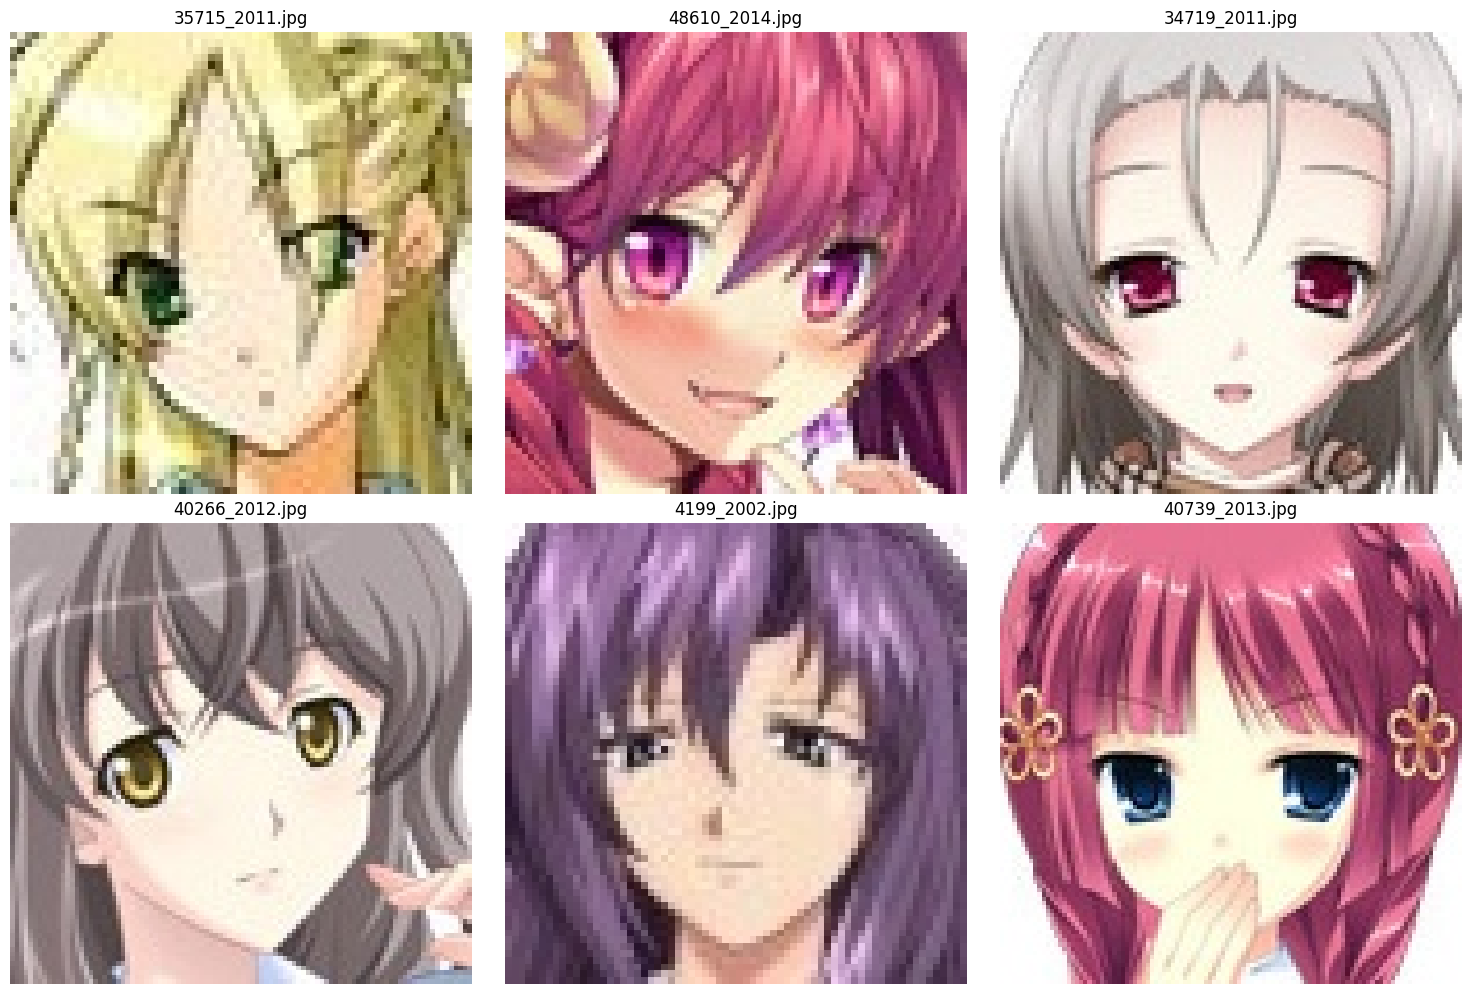

In [2]:
import cv2
path_dataset = '/kaggle/input/animefacedataset/images/'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filenames = os.listdir(path_dataset)[:6]

fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes = axes.flatten()


for i, file in enumerate(filenames):
    img_path = os.path.join(path_dataset,file)
    image = mpimg.imread(img_path)

    axes[i].imshow(image)
    axes[i].set_title(file)
    axes[i].axis('off')


plt.tight_layout()
plt.show()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob

class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform


        self.image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            self.image_paths.extend(glob.glob(os.path.join(folder_path, ext)))
            self.image_paths.extend(glob.glob(os.path.join(folder_path, ext.upper())))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])
train_folder = '/kaggle/input/animefacedataset/images'
print('Training Images:')
train_dataset = SimpleImageDataset(train_folder, transform=transform)
train_ds = DataLoader(
    train_dataset,
    batch_size=500,
    shuffle=True,
    num_workers=4,     
    pin_memory=True,       
    persistent_workers=True,
    prefetch_factor=2       
)

print(f'Количество изображений: {len(train_dataset)}')

Training Images:
Количество изображений: 63565


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

latent_dim = 64 
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        
     
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),   # 64->32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 32->16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 16->8
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 8->4
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 512 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 4->8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 8->16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 16->32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),    # 32->64
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)

        logvar = torch.clamp(self.fc_logvar(h), -20, 20)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 512, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def safe_reconstruction_loss(recon_x, x):
    
   
    recon_x = torch.clamp(recon_x, 1e-8, 1.0 - 1e-8)
    return F.binary_cross_entropy(recon_x, x, reduction='mean')

def safe_kl_divergence(mu, logvar):
  
    logvar = torch.clamp(logvar, -20, 20)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
 
    if torch.isnan(kl) or torch.isinf(kl):
        print("Warning: KL divergence is NaN/Inf, using backup value")
        return torch.tensor(0.0, device=mu.device)
    
    return kl

def safe_vae_loss(recon_x, x, mu, logvar, beta=1.0):
   
 
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    
  
    kl_loss = safe_kl_divergence(mu, logvar)
    
    total_loss = recon_loss + beta * kl_loss
    
  
    if torch.isnan(total_loss) or torch.isinf(total_loss):
        print(f"Warning: Total loss is NaN/Inf")
        print(f"Recon loss: {recon_loss.item()}")
        print(f"KL loss: {kl_loss.item()}")
        return torch.tensor(0.0, device=x.device), recon_loss, kl_loss
    
    return total_loss, recon_loss, kl_loss
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
latent_dim = 64
model = VAE(latent_dim=latent_dim).to(device) 
optimizer = optim.Adam(model.parameters(), lr=3e-3)

Device: cuda


In [6]:
def generate_img(model, batch_size=5, latent_dim=128, device=device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(batch_size, latent_dim, device=device)
        generated_images = model.decode(z)
    return generated_images

def safe_train_epoch(model, optimizer, dataloader, epoch, beta=1.0, log_interval=50):
    model.train()
    total_loss = 0
    total_recon_loss = 0 
    total_kl_loss = 0
    num_batches = len(dataloader)
    
    for batch_idx, x in enumerate(dataloader):
        try:
            x = x.to(device, non_blocking=True)
            
        
            if torch.isnan(x).any() or torch.isinf(x).any():
                print(f"Warning: NaN/Inf in input data at batch {batch_idx}")
                continue
            
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            
      
            if torch.isnan(recon_x).any() or torch.isnan(mu).any() or torch.isnan(logvar).any():
                print(f"Warning: NaN in model output at batch {batch_idx}")
                continue
            
         
            loss, recon_loss, kl_loss = safe_vae_loss(recon_x, x, mu, logvar, beta)
            
        
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss at batch {batch_idx}, skipping")
                continue
            
            loss.backward()
            

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            if batch_idx % log_interval == 0:
                progress = (batch_idx / num_batches) * 100
                print(f'🟢 Epoch {epoch+1} | {progress:5.1f}% | '
                      f'Loss: {loss.item():.4f} | '
                      f'Recon: {recon_loss.item():.4f} | '
                      f'KL: {kl_loss.item():.4f}')
        
        except RuntimeError as e:
            print(f"Error at batch {batch_idx}: {e}")
            print("Skipping this batch...")
            continue
    
    if num_batches > 0:
        return total_loss / num_batches, total_recon_loss / num_batches, total_kl_loss / num_batches
    else:
        return 0.0, 0.0, 0.0

def showimages(images, epoch):
    images = images.detach().cpu().permute(0, 2, 3, 1).clamp(0, 1).numpy()
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    axes = axes.flatten()
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    if epoch:
        plt.suptitle(f'Epoch {epoch}', fontsize=14)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def val(model, epoch, latent_dim=128, device='cuda'):
    model.eval()
    z = torch.randn(5, latent_dim, device=device)
    images = model.decode(z)
    showimages(images.cpu(), epoch+1)

🟢 Epoch 1 |   0.0% | Loss: 0.0864 | Recon: 0.0863 | KL: 0.0001
🟢 Epoch 1 |  39.1% | Loss: 0.0599 | Recon: 0.0598 | KL: 0.0001
🟢 Epoch 1 |  78.1% | Loss: 0.0583 | Recon: 0.0565 | KL: 0.0017
🟢 Epoch 2 |   0.0% | Loss: 0.0595 | Recon: 0.0569 | KL: 0.0026
🟢 Epoch 2 |  39.1% | Loss: 0.0587 | Recon: 0.0563 | KL: 0.0024
🟢 Epoch 2 |  78.1% | Loss: 0.0589 | Recon: 0.0561 | KL: 0.0028
🟢 Epoch 3 |   0.0% | Loss: 0.0583 | Recon: 0.0554 | KL: 0.0028
🟢 Epoch 3 |  39.1% | Loss: 0.0589 | Recon: 0.0557 | KL: 0.0032
🟢 Epoch 3 |  78.1% | Loss: 0.0580 | Recon: 0.0555 | KL: 0.0026
🟢 Epoch 4 |   0.0% | Loss: 0.0573 | Recon: 0.0546 | KL: 0.0027
🟢 Epoch 4 |  39.1% | Loss: 0.0577 | Recon: 0.0545 | KL: 0.0032
🟢 Epoch 4 |  78.1% | Loss: 0.0593 | Recon: 0.0556 | KL: 0.0036
🟢 Epoch 5 |   0.0% | Loss: 0.0581 | Recon: 0.0541 | KL: 0.0041
🟢 Epoch 5 |  39.1% | Loss: 0.0574 | Recon: 0.0528 | KL: 0.0046
🟢 Epoch 5 |  78.1% | Loss: 0.0569 | Recon: 0.0525 | KL: 0.0043


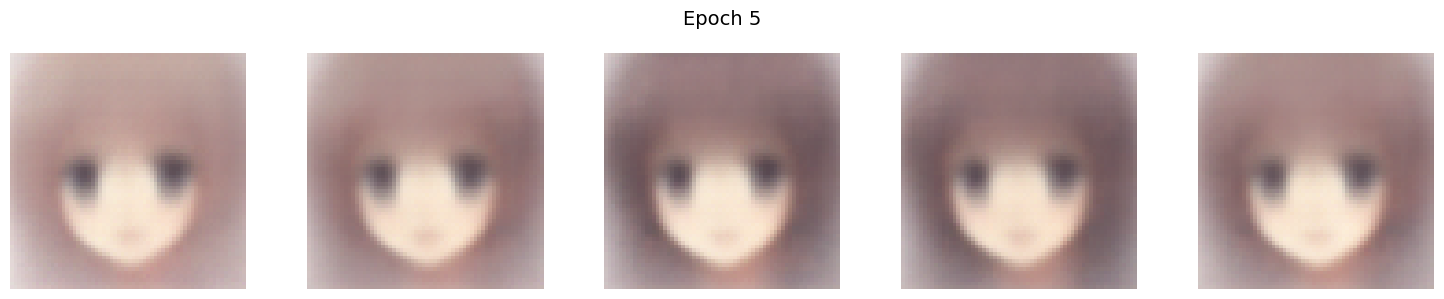

🟢 Epoch 6 |   0.0% | Loss: 0.0587 | Recon: 0.0535 | KL: 0.0052
🟢 Epoch 6 |  39.1% | Loss: 0.0569 | Recon: 0.0531 | KL: 0.0038
🟢 Epoch 6 |  78.1% | Loss: 0.0572 | Recon: 0.0523 | KL: 0.0049
🟢 Epoch 7 |   0.0% | Loss: 0.0575 | Recon: 0.0530 | KL: 0.0045
🟢 Epoch 7 |  39.1% | Loss: 0.0577 | Recon: 0.0525 | KL: 0.0052
🟢 Epoch 7 |  78.1% | Loss: 0.0573 | Recon: 0.0520 | KL: 0.0053
🟢 Epoch 8 |   0.0% | Loss: 0.0572 | Recon: 0.0527 | KL: 0.0045
🟢 Epoch 8 |  39.1% | Loss: 0.0578 | Recon: 0.0532 | KL: 0.0046
🟢 Epoch 8 |  78.1% | Loss: 0.0566 | Recon: 0.0511 | KL: 0.0055
🟢 Epoch 9 |   0.0% | Loss: 0.0554 | Recon: 0.0503 | KL: 0.0050
🟢 Epoch 9 |  39.1% | Loss: 0.0584 | Recon: 0.0533 | KL: 0.0051
🟢 Epoch 9 |  78.1% | Loss: 0.0563 | Recon: 0.0513 | KL: 0.0050
🟢 Epoch 10 |   0.0% | Loss: 0.0572 | Recon: 0.0522 | KL: 0.0050
🟢 Epoch 10 |  39.1% | Loss: 0.0564 | Recon: 0.0516 | KL: 0.0048
🟢 Epoch 10 |  78.1% | Loss: 0.0567 | Recon: 0.0523 | KL: 0.0044


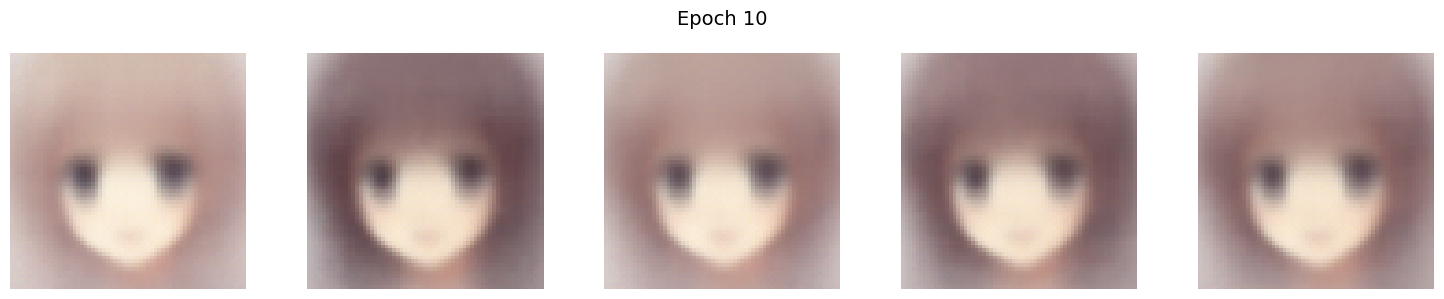

🟢 Epoch 11 |   0.0% | Loss: 0.0567 | Recon: 0.0515 | KL: 0.0052
🟢 Epoch 11 |  39.1% | Loss: 0.0553 | Recon: 0.0508 | KL: 0.0045
🟢 Epoch 11 |  78.1% | Loss: 0.0583 | Recon: 0.0537 | KL: 0.0046
🟢 Epoch 12 |   0.0% | Loss: 0.0566 | Recon: 0.0515 | KL: 0.0051
🟢 Epoch 12 |  39.1% | Loss: 0.0582 | Recon: 0.0542 | KL: 0.0040
🟢 Epoch 12 |  78.1% | Loss: 0.0587 | Recon: 0.0540 | KL: 0.0047
🟢 Epoch 13 |   0.0% | Loss: 0.0572 | Recon: 0.0517 | KL: 0.0055
🟢 Epoch 13 |  39.1% | Loss: 0.0579 | Recon: 0.0531 | KL: 0.0048
🟢 Epoch 13 |  78.1% | Loss: 0.0567 | Recon: 0.0518 | KL: 0.0049
🟢 Epoch 14 |   0.0% | Loss: 0.0583 | Recon: 0.0532 | KL: 0.0050
🟢 Epoch 14 |  39.1% | Loss: 0.0559 | Recon: 0.0518 | KL: 0.0041
🟢 Epoch 14 |  78.1% | Loss: 0.0572 | Recon: 0.0527 | KL: 0.0045
🟢 Epoch 15 |   0.0% | Loss: 0.0574 | Recon: 0.0527 | KL: 0.0046
🟢 Epoch 15 |  39.1% | Loss: 0.0561 | Recon: 0.0511 | KL: 0.0050
🟢 Epoch 15 |  78.1% | Loss: 0.0574 | Recon: 0.0521 | KL: 0.0052


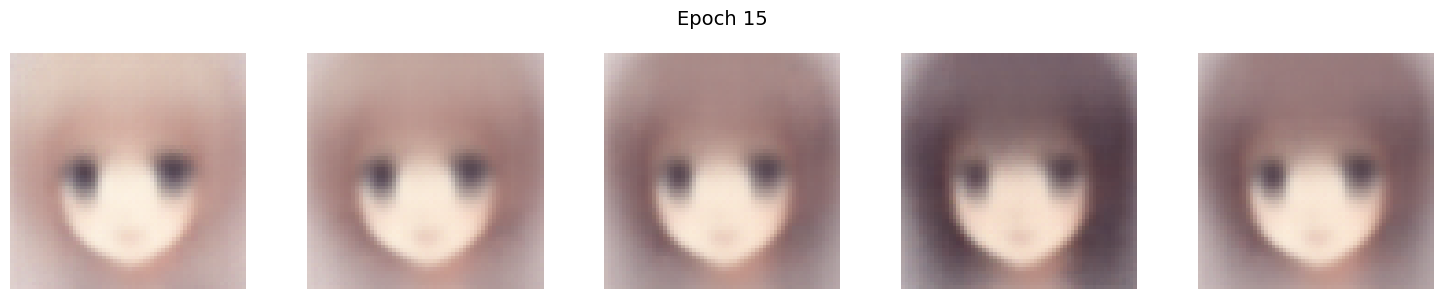

🟢 Epoch 16 |   0.0% | Loss: 0.0568 | Recon: 0.0523 | KL: 0.0045
🟢 Epoch 16 |  39.1% | Loss: 0.0572 | Recon: 0.0523 | KL: 0.0049
🟢 Epoch 16 |  78.1% | Loss: 0.0576 | Recon: 0.0526 | KL: 0.0049
🟢 Epoch 17 |   0.0% | Loss: 0.0585 | Recon: 0.0534 | KL: 0.0051
🟢 Epoch 17 |  39.1% | Loss: 0.0575 | Recon: 0.0525 | KL: 0.0050
🟢 Epoch 17 |  78.1% | Loss: 0.0574 | Recon: 0.0525 | KL: 0.0049
🟢 Epoch 18 |   0.0% | Loss: 0.0575 | Recon: 0.0522 | KL: 0.0053
🟢 Epoch 18 |  39.1% | Loss: 0.0571 | Recon: 0.0521 | KL: 0.0050
🟢 Epoch 18 |  78.1% | Loss: 0.0585 | Recon: 0.0534 | KL: 0.0052
🟢 Epoch 19 |   0.0% | Loss: 0.0587 | Recon: 0.0531 | KL: 0.0056
🟢 Epoch 19 |  39.1% | Loss: 0.0573 | Recon: 0.0523 | KL: 0.0051
🟢 Epoch 19 |  78.1% | Loss: 0.0570 | Recon: 0.0522 | KL: 0.0048
🟢 Epoch 20 |   0.0% | Loss: 0.0570 | Recon: 0.0520 | KL: 0.0050
🟢 Epoch 20 |  39.1% | Loss: 0.0556 | Recon: 0.0509 | KL: 0.0047
🟢 Epoch 20 |  78.1% | Loss: 0.0577 | Recon: 0.0529 | KL: 0.0048


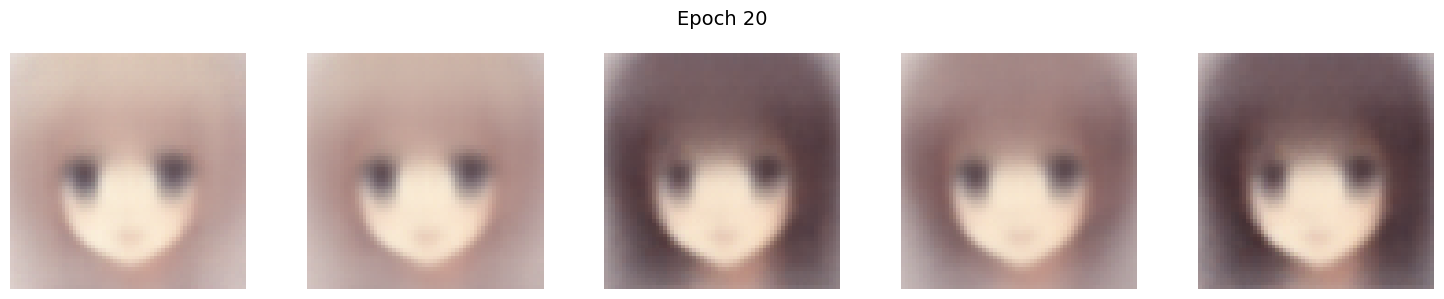

🟢 Epoch 21 |   0.0% | Loss: 0.0578 | Recon: 0.0534 | KL: 0.0043
🟢 Epoch 21 |  39.1% | Loss: 0.0573 | Recon: 0.0522 | KL: 0.0051
🟢 Epoch 21 |  78.1% | Loss: 0.0578 | Recon: 0.0527 | KL: 0.0051
🟢 Epoch 22 |   0.0% | Loss: 0.0566 | Recon: 0.0519 | KL: 0.0047
🟢 Epoch 22 |  39.1% | Loss: 0.0573 | Recon: 0.0525 | KL: 0.0048
🟢 Epoch 22 |  78.1% | Loss: 0.0570 | Recon: 0.0521 | KL: 0.0049
🟢 Epoch 23 |   0.0% | Loss: 0.0564 | Recon: 0.0522 | KL: 0.0043
🟢 Epoch 23 |  39.1% | Loss: 0.0571 | Recon: 0.0521 | KL: 0.0050
🟢 Epoch 23 |  78.1% | Loss: 0.0580 | Recon: 0.0536 | KL: 0.0045
🟢 Epoch 24 |   0.0% | Loss: 0.0587 | Recon: 0.0538 | KL: 0.0049
🟢 Epoch 24 |  39.1% | Loss: 0.0572 | Recon: 0.0521 | KL: 0.0050
🟢 Epoch 24 |  78.1% | Loss: 0.0558 | Recon: 0.0508 | KL: 0.0050
🟢 Epoch 25 |   0.0% | Loss: 0.0572 | Recon: 0.0524 | KL: 0.0048
🟢 Epoch 25 |  39.1% | Loss: 0.0568 | Recon: 0.0519 | KL: 0.0049
🟢 Epoch 25 |  78.1% | Loss: 0.0579 | Recon: 0.0527 | KL: 0.0052


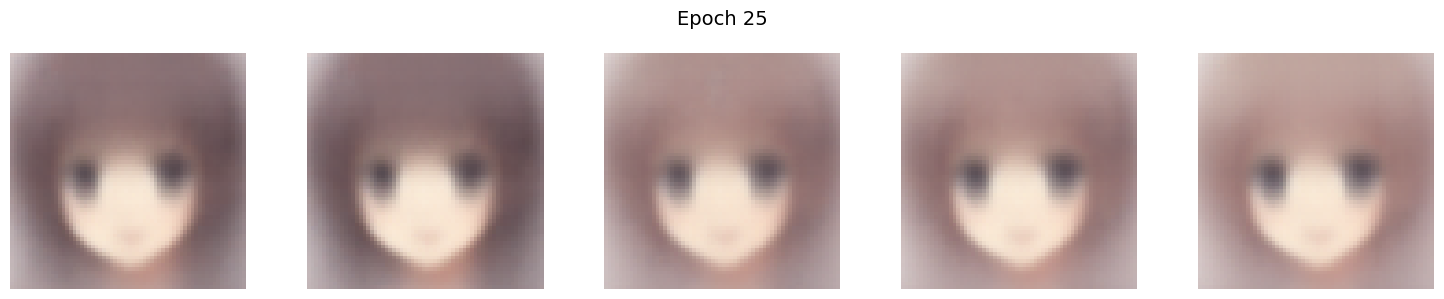

In [7]:
num_epochs = 25
avg_loss = []
avg_recon_loss = []
avg_kl_loss = []
for epoch in range(num_epochs):
    avg_loss_1, avg_recon_loss_1, avg_kl_loss_1 = safe_train_epoch(model, optimizer, train_ds, epoch)
    avg_loss.append(avg_loss_1)
    avg_recon_loss.append(avg_recon_loss_1)
    avg_kl_loss.append(avg_kl_loss_1)
    
    if (epoch + 1) % 5 == 0:
        val(model, epoch, latent_dim, device)

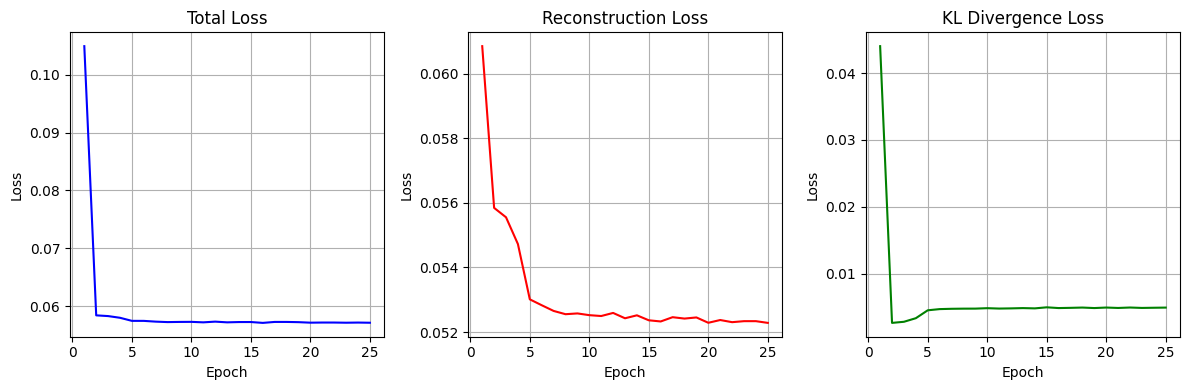

In [8]:
import matplotlib.pyplot as plt

def plot_losses(avg_loss, avg_recon_loss, avg_kl_loss):
    
    epochs = range(1, len(avg_loss) + 1)
    
    plt.figure(figsize=(12, 4))
    
    # Total Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, avg_loss, 'b-', label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Reconstruction Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, avg_recon_loss, 'r-', label='Reconstruction Loss')
    plt.title('Reconstruction Loss') 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # KL Divergence Loss
    plt.subplot(1, 3, 3)
    plt.plot(epochs, avg_kl_loss, 'g-', label='KL Divergence')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_losses(avg_loss, avg_recon_loss, avg_kl_loss)